# Visualisation of the trials

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import json
from sympy import sympify, latex

from new_analysis import eq_algo_summary, get_job_status
from constants import TEMP_DIR, ALGORITHMS

In [2]:
#import scienceplots
#plt.style.use(['science', 'notebook'])
plt.rcParams['axes.linewidth'] = 2
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('axes',labelsize=12)
plt.rc('legend',fontsize=12)

## Read the data

In [3]:
def read_data(read_from_file=True, not_found=np.nan):
    if read_from_file:
        with open(TEMP_DIR / "eq_algo_summary.json", "r") as f:
            summary_dict = json.load(f)
    else:
        get_job_status(state="finished", new_status=True)
        summary_dict = eq_algo_summary()

    # create a dataframe from the summary dictionary
    eq_names = [s.split(" ")[1] for s in summary_dict.keys()]
    summary_df = pd.DataFrame(columns=ALGORITHMS, index=eq_names)
    summary_df.index.name = "Equation"
    
    for eq in summary_dict:
        for algo in summary_dict[eq]:
            last_n = np.array(summary_dict[eq][algo]["last_n"], dtype=float)
            # replace  499 with nan
            last_n[last_n == 499] = not_found
            summary_df.loc[str(eq.split(" ")[1]), algo] = last_n


    # Read the CSV file into a dictionary
    equations_dict = pd.read_csv('feynman.csv', index_col='Filename')['Formula'].to_dict()
    # Add the equations to the dataframe
    summary_df['formula'] = summary_df.index.map(equations_dict)
    return summary_df

In [4]:
summary_df = read_data(read_from_file=True, not_found=np.nan)
print(summary_df.index)
# print the numeb

Index(['II.11.17', 'I.24.6', 'II.11.20', 'III.13.18', 'I.13.4', 'I.6.2b',
       'I.30.3', 'II.11.3', 'I.34.14', 'I.11.19', 'I.38.12', 'III.7.38',
       'III.10.19', 'I.6.2', 'I.27.6', 'I.12.2', 'III.15.12', 'II.34.2a',
       'I.40.1', 'II.6.11', 'I.12.11', 'III.19.51', 'I.18.4', 'I.6.2a',
       'II.34.11', 'II.6.15b', 'I.8.14', 'II.11.28', 'II.34.29b', 'I.10.7',
       'I.32.5', 'I.16.6', 'II.35.18', 'I.13.12', 'II.36.38', 'I.37.4',
       'II.2.42', 'II.21.32', 'III.14.14', 'II.35.21', 'III.15.14', 'I.50.26'],
      dtype='object', name='Equation')


## Visualise the data

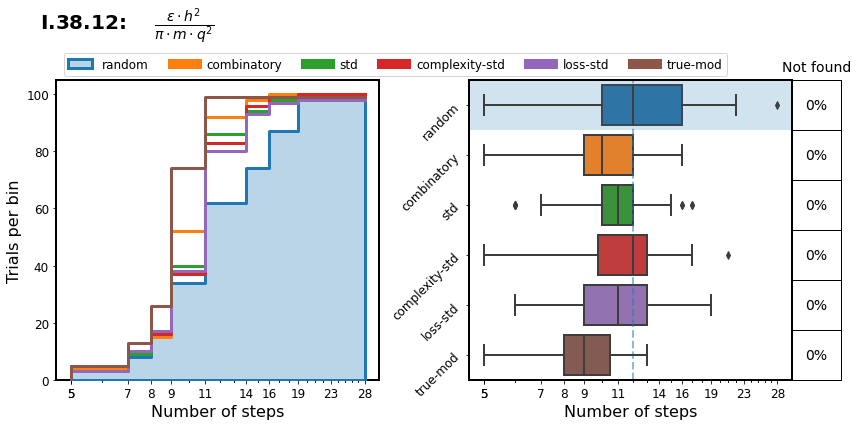

Plots saved in "plots.pdf"


In [30]:
# Set to True to save the plots as a pdf
save_as_pdf = False
save_as_img = True
folder = "/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots/per_equation"

# Define the number of bins
num_bins = 10
offset = 10

# copy the dataframe
summary_df = read_data(read_from_file=True, not_found=np.nan)
# add a column with the equation latex formulas from the feynman.csv file. use sympy to convert the string to latex
# load the feynman.csv file


def plot_hist_and_boxplot(pdf=None, log_scale=False):
    """Plot histogram with KDE for each equation and algorithm on the left, and a boxplot on the right"""

    for j, equation in enumerate(summary_df.index):
        # DEBUG
        if j > 10:
            break
        if j < 10:
            continue

        # Find the bin edges with the highest count
        max_bin_edges = None
        max_bin_count = 0

        _min = 500
        _max = 0

        for column in summary_df.columns[:-1]: # skip the last column, which is the formula
            # # account for log scale
            # bin_edges = np.histogram_bin_edges(summary_df.loc[equation, column])
            # print(bin_edges, len(bin_edges))
            # bin_counts = np.histogram(summary_df.loc[equation, column], bins=bin_edges)[0]
            # # Find the bin edges with the highest count
            # max_count = np.max(bin_counts)
            # print(max_count)
            # if max_count > max_bin_count:
            #     max_bin_count = max_count
            #     max_bin_edges = bin_edges
            # find min and max of the data
            _min = min(_min, np.nanmin(summary_df.loc[equation, column]))
            _max = max(_max, np.nanmax(summary_df.loc[equation, column]))

        # rename the true-confusion column to true-mod
        summary_df.rename(columns={"true-confusion": "true-mod"}, inplace=True)
        ALGORITHMS = summary_df.columns[:-1]
        
        # create bin edges with log scale
        if log_scale:
            bin_edges = np.logspace(np.log10(_min), np.log10(_max), num_bins+1, dtype=int)
        else:
            bin_edges = np.linspace(_min, _max, num_bins+1, dtype=int)
        
            
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        palette = sns.color_palette("tab10", len(ALGORITHMS))
        try:
            for i, column in enumerate(summary_df.columns[:-1]):
                # Use `bins` parameter to set the number of bins
                sns.histplot(summary_df.loc[equation, column], log_scale=False, bins=bin_edges, ax=ax[0], label=column, fill=(column=="random"), linewidth=3, element="step", color=palette[i], alpha=(0.3 if column=="random" else 1), zorder=10)
            # Plot the boxplot with the algorithm names on the x-axis
            sns.boxplot(data=summary_df.loc[equation].iloc[:-1], orient="h", ax=ax[1], showfliers=True, linewidth=2, palette=palette, zorder=10)
            # add a line for the mean of the random algorithm
            # get color of the random algorithm (seaborn)
            random_color = sns.color_palette()[0]
            ax[1].axvline(np.nanmedian(summary_df.loc[equation, 'random']), color=random_color, linestyle='--', linewidth=2, alpha=0.5)
            # add a background color to the random algorithm
            ax[1].axhspan(-0.5, 0.5, facecolor=random_color, alpha=0.2)
            
            
        except Exception as e:
            print(f"Could not plot {equation}")
            print(e)
            continue
        # Add x-ticks to the boxplot
        ax[1].set_yticklabels(ALGORITHMS, rotation=45, horizontalalignment='right')

        #ax[0].set_title("Histogram")
        #ax[1].set_title("Boxplot")
        ax[0].set_xlabel("Number of steps", fontsize=16)
        ax[0].set_ylabel("Trials per bin", fontsize=16)
        ax[1].set_xlabel("Number of steps", fontsize=16)

        #change the x-axis of the ax[0] to semilog
        if log_scale:
            ax[0].set_xscale('log')
            ax[1].set_xscale('log')
            # replace the x-ticks with the bin edges
            # make minor ticks between the bin edges
            minor_bin_edges = np.linspace(_min, _max, num_bins*10+1, dtype=int)
            ax[0].set_xticks(minor_bin_edges, minor=True)
            ax[0].set_xticklabels([], minor=True)
            ax[1].set_xticks(minor_bin_edges, minor=True)
            ax[1].set_xticklabels([], minor=True)
            
            
            ax[0].set_xticks(bin_edges, minor=False)
            ax[0].set_xticklabels(bin_edges, minor=False)
            ax[1].set_xticks(bin_edges, minor=False)
            ax[1].set_xticklabels(bin_edges, minor=False)


        # add a table to the plot with the number of nan values for each algorithm
        # create a table with the number of nan values for each algorithm
        nan_table = pd.DataFrame(index=ALGORITHMS, columns=["Not found"])#
        for column in summary_df.columns[:-1]:
            # in percentage
            nan_table.loc[column, "Not found"] = str(int(np.sum(np.isnan(summary_df.loc[equation, column])) / len(summary_df.loc[equation, column]) * 100)) + "%"

    
        # create the table
        table = ax[1].table(cellText=nan_table.values, loc='right', bbox=[1.0, 0.0, 0.15, 1.0], cellLoc='center')
        # set the font size of the table
        table.set_fontsize(14)
        # add text above the table
        ax[1].text(1.075, 1.02, "Not found", fontsize=14, transform=ax[1].transAxes, ha='center', va='bottom')
        
        fig.suptitle(equation+":    "+latex(sympify(summary_df.loc[equation, 'formula']), mul_symbol="dot", mode="inline", fold_frac_powers=True, parenthesize_super=True), fontsize=20, weight="bold", ha="left", x=0.05, y=0.98)
        # add padding below the title
        fig.tight_layout()
        # make the legend below the plot
        leg = ax[0].legend(loc='upper center', bbox_to_anchor=(1.05, 1.11), ncol=6, fancybox=True, fontsize=12)
        for line in leg.get_lines():
            line.set_linewidth(10.0)
        
        if save_as_img:
            plt.savefig(f"{folder}/{equation}.png", dpi=20, bbox_inches='tight', pad_inches=0.0, transparent=False)
        if pdf:
            pdf.savefig(fig)
        else:
            plt.show()
        plt.close(fig)

        

    print('Plots saved in "plots.pdf"')


if save_as_pdf:
    with PdfPages(TEMP_DIR / 'plots.pdf') as pdf:
        plot_hist_and_boxplot(pdf=pdf, log_scale=True)
else:
    plot_hist_and_boxplot(log_scale=True)

In [33]:
# ridge plot
for equation in summary_df.index:
    max_bin_edges = None
    max_bin_count = 0
    for column in summary_df.columns:
        bin_edges = np.histogram_bin_edges(summary_df.loc[equation, column], bins=15)
        bin_counts = np.histogram(summary_df.loc[equation, column], bins=bin_edges)[0]
        # Find the bin edges with the highest count
        max_count = np.max(bin_counts)
        if max_count > max_bin_count:
            max_bin_count = max_count
            max_bin_edges = bin_edges
    df = pd.DataFrame(columns=["Algorithm", "Steps"])
    for column in summary_df.columns:
        df.loc[len(df)] = [column, summary_df.loc[equation, column].tolist()]
    df = df.explode("Steps")
    palette = sns.color_palette("Set2", len(ALGORITHMS))
    g = sns.FacetGrid(df, row="Algorithm", aspect=8, height=1.2, palette=palette, hue="Algorithm")
    g.map_dataframe(sns.histplot, x="Steps", bins=max_bin_edges)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .5, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "Algorithm")
    g.set_titles("")
    g.set(yticks=[], xlabel="Number of steps")
    g.despine(left=True)
    # remove y label
    g.set(ylabel="")
    plt.suptitle('Steps to convergence for each algorithm', y=0.98)
    plt.show()
    break # DEBUG
    

UFuncTypeError: ufunc 'minimum' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> None

## Aggregated plot

In [4]:
# plot all the equations in one boxplot.
# create a dataframe with the median number of steps for each equation and algorithm
# add to ALGORITHMS the column "not_found" which contains the number of nan values for each algorithm
summary_df = read_data(read_from_file=True, not_found=np.nan)
median_df = pd.DataFrame(index=summary_df.index, columns=list(ALGORITHMS).append([f"{algorithm}_not_found" for algorithm in ALGORITHMS]), dtype=float)
for equation in summary_df.index:
    for column in summary_df.columns[:-1]:
        median_df.loc[equation, column] = np.nanmedian(summary_df.loc[equation, column])
        # count the number of nan values
        median_df.loc[equation, column+"_not_found"] = np.sum(np.isnan(summary_df.loc[equation, column]))


/beegfs/desy/user/bornemaf/conda/envs/PySR/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


/tmp/ipykernel_3939/3235461057.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  random_hist = sns.histplot(data=algorithms_df['random'], ax=ax[1], palette=sns.color_palette(), linewidth=2, element="step", fill=True, bins=bins, alpha=0.3)
/tmp/ipykernel_3939/3235461057.py:10: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  algo_hist = sns.histplot(data=algorithms_df.loc[:, algorithms_df.columns != 'random'], ax=ax[1], palette=sns.color_palette()[1:], linewidth=2, element="step", fill=False, bins=bins)


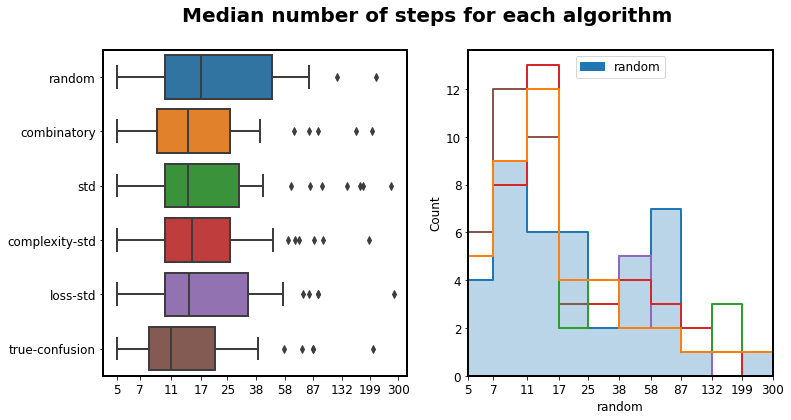

In [8]:
# make a boxplot and histogram for each algorithm
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

num = 10
bins = np.logspace(np.log10(5), np.log10(300), num+1, dtype=int)

algorithms_df = median_df[["random", "combinatory", "std", "complexity-std", "loss-std", "true-confusion"]]
sns.boxplot(data=algorithms_df, ax=ax[0], palette=sns.color_palette(), linewidth=2, orient="h")
random_hist = sns.histplot(data=algorithms_df['random'], ax=ax[1], palette=sns.color_palette(), linewidth=2, element="step", fill=True, bins=bins, alpha=0.3)
algo_hist = sns.histplot(data=algorithms_df.loc[:, algorithms_df.columns != 'random'], ax=ax[1], palette=sns.color_palette()[1:], linewidth=2, element="step", fill=False, bins=bins)
# log scale x-axis
ax[0].set_xscale('log')
ax[1].set_xscale('log')

# get the first and last bin edges to set the x-axis limits
data_random = random_hist.get_lines()[0].get_data()[0]
data_algo = algo_hist.get_lines()[0].get_data()[0]
data = np.concatenate((data_random, data_algo))
first_bin_edge = data[0]
last_bin_edge = data[-1]



# Set x-axis limits to include the left and right borders
plt.xlim(left=first_bin_edge, right=last_bin_edge)

# change the x-ticks to log scale

ax[0].set_xticks(bins, minor=False)
ax[0].set_xticks([], minor=True)
ax[0].set_xticklabels(bins, minor=False)
ax[1].set_xticks(bins, minor=False)
ax[1].set_xticks([], minor=True)
ax[1].set_xticklabels(bins, minor=False)

# add the random histogram to the legend
handles, labels = ax[1].get_legend_handles_labels()
handles.append(matplotlib.patches.Patch(color=sns.color_palette()[0], label="random"))
ax[1].legend(handles=handles, loc='upper center')

# title
fig.suptitle("Median number of steps for each algorithm", fontsize=20, weight="bold")

# show plots
plt.show()

## Aggregated difference plot

In [37]:
def median_difference(not_found_num=650):
    summary_df = read_data(read_from_file=True, not_found=not_found_num)
    median_difference_df = pd.DataFrame(index=summary_df.index, columns=list(ALGORITHMS[1:]).append([f"{algorithm}_not_found" for algorithm in ALGORITHMS[1:]]), dtype=float)
    for equation in summary_df.index:
        random_median = np.nanmedian(summary_df.loc[equation, "random"])
        for column in summary_df.columns[1:-1]:
            median_difference_df.loc[equation, column] = random_median - np.nanmedian(summary_df.loc[equation, column])
            # count the number of values that are not_found_num
            median_difference_df.loc[equation, column+"_not_found"] = np.sum(summary_df.loc[equation, column] == not_found_num)
    # remove the rows with nan values
    
    median_difference_df = median_difference_df.dropna()
    return median_difference_df

def linspace_with_zero(xmin, xmax, num, log=False):
    """Create a linspace with zero in the middle. When log is True, the linspace is log spaced in positive and negative direction"""
    half_num = num // 2  # Number of elements on each side of zero
    step = (xmax - xmin) / (num - 1)  # Step size between elements
    if not log:
        neg_values = np.linspace(xmin, 0.0, half_num, endpoint=False, dtype=int)  # Values on the negative side
        pos_values = np.linspace(0.0, xmax, num - half_num, dtype=int)  # Values on the positive side
    else:
        pos_values = np.logspace(0.0, np.log10(xmax), num - half_num, dtype=int)
        neg_values = -np.logspace(0.0, np.log10(-xmin), half_num, endpoint=True, dtype=int)
        # reverse the negative values
        neg_values = neg_values[::-1]
        neg_values = np.append(neg_values, 0)
    return np.concatenate((neg_values, pos_values))

/beegfs/desy/user/bornemaf/conda/envs/PySR/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


combinatory mu: 20.2, std: 89.25208681033739
std mu: 11.4875, std: 92.28065124255463
complexity-std mu: 24.1, std: 80.4423862152286
loss-std mu: 20.3875, std: 86.85465499183104
true-confusion mu: 12.5375, std: 122.85476117656165


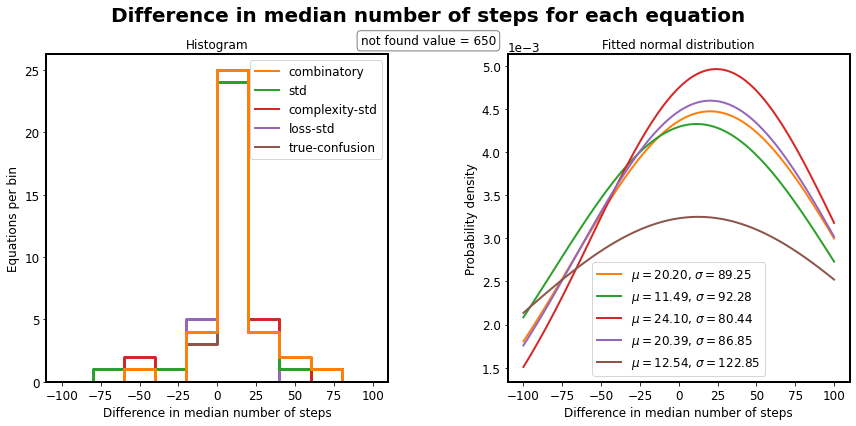

In [5]:

not_found = 650
median_difference_df = median_difference(not_found_num = not_found)

# plot the dataframe in a histogram around 0
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

num = 10
xmin, xmax = -100, 100
bins = linspace_with_zero(xmin, xmax, num+1)
palette = sns.color_palette()[1:6]

algorithms_df = median_difference_df[["combinatory", "std", "complexity-std", "loss-std", "true-confusion"]]
sns.histplot(data=algorithms_df, ax=ax[0], palette=palette, linewidth=3, element="step", fill=False, bins=bins, legend=True)

for i,algo in enumerate(ALGORITHMS[1:]):
    # plot the median
    median = np.nanmean(median_difference_df[algo])
    #print(f"{algo} median: {median}")
    #ax[0].axvline(median, color=palette[i], linestyle='--', linewidth=2)


# fit normal distribution to every algorithm
from scipy.stats import norm
for i, algo in enumerate(ALGORITHMS[1:]):
    # fit a normal distribution to the data
    mu, std = norm.fit(median_difference_df[algo])
    print(f"{algo} mu: {mu}, std: {std}")
    # plot the pdf
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax[1].plot(x, p, linewidth=2, label=f"$\\mu = {mu:.2f}$, $\\sigma = {std:.2f}$", color=palette[i])

# add a text box with the mean and std of each algorithm
# textstr = ""

# for algo in ALGORITHMS[1:]:
#     textstr += f"{algo} mean: {np.nanmean(median_difference_df[algo]):.2f}, std: {np.nanstd(median_difference_df[algo]):.2f}"
# props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black")
# ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=12,
#         verticalalignment='top', bbox=props)


# title
fig.suptitle("Difference in median number of steps for each equation", fontsize=20, weight="bold")
ax[0].set_xlabel("Difference in median number of steps")
ax[0].set_ylabel("Equations per bin")
ax[1].set_xlabel("Difference in median number of steps")
ax[1].set_ylabel("Probability density")
# set ax[1] to scientific notation
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# create custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=palette[i], lw=2) for i in range(len(ALGORITHMS[1:]))]
ax[0].legend(custom_lines, ALGORITHMS[1:])

#title
ax[0].set_title("Histogram")
ax[1].set_title("Fitted normal distribution")

# add textbox with not found value in the middle of the figure, not ax[0]
textstr = f"not found value = {not_found}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black")
ax[1].text(0.5, 0.90, textstr, transform=fig.transFigure, fontsize=12, bbox=props, ha="center", va="center")

# show legend
ax[1].legend()


# show plots
plt.tight_layout()
plt.show()


In [9]:
# make one plot for each algorithm
def difference_plot_each(pdf=None, num=10, xmin=-500, xmax=500, not_found_num = 650):

    


    from scipy.stats import norm
    bins = linspace_with_zero(xmin, xmax, num+1, log=True)
    palette = sns.color_palette()[1:6]
    median_difference_df = median_difference(not_found_num = not_found_num)

    for i, algo in enumerate(ALGORITHMS[1:]):
        fig, ax = plt.subplot_mosaic([['left', 'upper right'],
                                ['left', 'lower right']],
                                figsize=(12, 6), layout="constrained")
        
        sns.histplot(data=median_difference_df[algo], ax=ax["left"], color=palette[i], linewidth=3, element="step", fill=True, bins=bins, legend=True, alpha=0.5)
        # plot the median
        median = np.nanmean(median_difference_df[algo])

        # fit a normal distribution to the data
        mu, std = norm.fit(median_difference_df[algo])
        # plot the pdf
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax["upper right"].plot(x, p, linewidth=2, label=f"$\\mu = {mu:.2f}$, $\\sigma = {std:.2f}$", color=palette[i])
        ax["upper right"].axvline(mu, color=palette[i], linestyle='--', linewidth=2)
        ax["upper right"].axvline(0, color="black", linestyle='--', linewidth=2)

        # add text box with mean and std
        textstr = f"$\\mu = {np.nanmean(median_difference_df[algo]):.2f}, \\sigma = {np.nanstd(median_difference_df[algo]):.2f}$"
        props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black")
        ax["upper right"].text(0.05, 0.95, textstr, transform=ax["upper right"].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
        
        # add a boxplot to the lower right
        sns.boxplot(data=median_difference_df[algo], ax=ax["lower right"], color=palette[i], linewidth=3, orient="h")
        
        
        # make x axis logarithmic
        ax["lower right"].set_xscale("symlog")
        #ax["upper right"].set_xscale("symlog")
        ax["left"].set_xscale("symlog")
        # set x ticks
        ax["left"].set_xticks(bins)
        ax["left"].set_xticklabels(bins, minor=False)
        ax["left"].set_xticks([], minor=True)
        # title
        fig.suptitle(f"Difference in median number of steps for {algo}", fontsize=20, weight="bold")
        ax["left"].set_xlabel("$Median_{random} - median_{algorithm}$")
        ax["left"].set_ylabel("Equations per bin")
        ax["upper right"].set_xlabel("Difference in median number of steps")
        ax["upper right"].set_ylabel("Probability density")
        # set ax[1] to scientific notation
        ax["upper right"].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        # add textbox with not found value in the middle of the figure, not ax[0]
        textstr = f"not found value = {not_found_num}"
        props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black")
        ax["upper right"].text(0.5, 0.90, textstr, transform=fig.transFigure, fontsize=12, bbox=props, ha="center", va="center")
        
        plt.tight_layout()
        if pdf:
            pdf.savefig(fig)
        else:
            plt.show()
        plt.close(fig)

In [63]:
# change matplotlib properties to make it look better
# Set font sizes for different plot elements
plt.rc('font', size=16)          # Base font size for text elements
plt.rc('axes', titlesize=18)     # Title font size
plt.rc('axes', labelsize=16)     # Axis label font size
plt.rc('xtick', labelsize=12)    # X-axis tick label font size
plt.rc('ytick', labelsize=14)    # Y-axis tick label font size
plt.rc('legend', fontsize=14)    # Legend font size
# Set line widths for different plot elements
plt.rc('axes', linewidth=1.5)    # Width of axis lines
plt.rc('lines', linewidth=3)     # Width of plot lines
plt.rc('lines', markersize=8)    # Size of plot markers
plt.rc('xtick.major', width=1.5) # Width of tick mark lines
plt.rcParams["text.usetex"] = False

In [26]:
# make one plot for each algorithm
def difference_plot_each(pdf=None, num=10, xmin=-500, xmax=500, not_found_num = 650, save_as_img=False):

    summary_df = read_data(read_from_file=True, not_found=np.nan)
    # for every algorithm, get the number of nan values
    not_found = {}
    for alg in summary_df.columns[:-1]:
        nan_count = 0
        for eq in summary_df.index:
            # get the number of nan values
            step_list = summary_df.loc[eq, alg]
            # Convert the step_list to a numeric NumPy array if applicable
            if isinstance(step_list, list):
                step_list = np.array(step_list, dtype=np.float64)
                
            # count the number of nan values in the list
            try:
                nan_count_eq = np.count_nonzero(np.isnan(step_list))
            except TypeError as e:
                raise TypeError(f"Error in {alg} with {eq} and {alg}") from e
            # add to the total nan count
            nan_count += nan_count_eq
        not_found[alg] = nan_count

    from scipy.stats import norm
    bins = linspace_with_zero(xmin, xmax, num+1, log=True)
    palette = sns.color_palette()[1:6]
    median_difference_df = median_difference(not_found_num = not_found_num)

    for i, algo in enumerate(ALGORITHMS[1:]):
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        fig.subplots_adjust(wspace=0.0, hspace=0.5)
        
        sns.histplot(data=median_difference_df[algo], ax=ax[0], color=palette[i], linewidth=3, element="step", fill=True, bins=bins, legend=True, alpha=0.5)
        # add the percentage of median_difference_df entries that are less than 0 and greater than 0 to the plot in form of a text box
        # get the number of entries that are less than 0 and greater than 0
        less_than_zero = median_difference_df[median_difference_df[algo] <= 0][algo].count()
        greater_than_zero = median_difference_df[median_difference_df[algo] > 0][algo].count()
        # calculate the percentage
        less_than_zero_percentage = less_than_zero / median_difference_df[algo].count() * 100
        greater_than_zero_percentage = greater_than_zero / median_difference_df[algo].count() * 100
        # add the text boxes to the middle left and right of the histogram
        ax[0].text(0.25, 0.50, f"{less_than_zero_percentage:.2f}%", transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor="black"), horizontalalignment='center')
        ax[0].text(0.75, 0.50, f"{greater_than_zero_percentage:.2f}%", transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor="black"), horizontalalignment='center')
        # plot the empirical median and standard deviation
        median = np.nanmean(median_difference_df[algo])
        std = np.nanstd(median_difference_df[algo], ddof=1)
        # count the not found values for the algorithm in every equation. They have a value of not_found_num
        not_found_sum = int(not_found[algo])
        ax[0].text(0.02, 0.95, f"$\\mu = {median:.2f}, \\sigma = {std:.2f}$\nEQs not found = {not_found_sum}",
                transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black"))
        # add a vertical line at 0
        ax[0].axvline(0, color="black", linestyle='--', linewidth=2)
        ax[1].axvline(0, color="black", linestyle='--', linewidth=2)

        
        # add a boxplot to the lower right
        #sns.violinplot(data=median_difference_df[algo], ax=ax[1], color=palette[i], inner=None, linewidth=0, orient="h", )
        sns.boxplot(data=median_difference_df[algo], ax=ax[1], color=palette[i], linewidth=3, orient="h", boxprops={'zorder': 2}, width=0.4)
        
        
        # make x axis logarithmic
        ax[1].set_xscale("symlog")
        #ax["upper right"].set_xscale("symlog")
        ax[0].set_xscale("symlog")
        # set x ticks
        ax[1].set_xticks(bins)
        ax[1].set_xticklabels(bins, minor=False)
        ax[1].set_xticks([], minor=True)
        ax[0].set_xticks(bins)
        ax[0].set_xticklabels(bins, minor=False)
        ax[0].set_xticks([], minor=True)
        # title
        fig.suptitle(f"Difference in median number of steps for {algo if algo != 'true-confusion' else 'true-mod'}", fontsize=20, weight="bold")
        ax[1].set_xlabel("$median_{random} - median_{approach}$", fontsize=16)
        ax[0].set_xlabel("$median_{random} - median_{approach}$", fontsize=16)
        ax[0].set_ylabel("Equations per bin", fontsize=16)
        # remove y label from ax[1]
        ax[1].set_ylabel("")
        ax[1].set_yticks([])

        # add grid to ax[1]
        ax[1].grid(True, axis="x", zorder=0, color="grey", linestyle="--", linewidth=1)


        # add textbox with not found value in the middle of the figure, not ax[0]
        textstr = f"not found value = {not_found_num}"
        props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="white")
        ax[1].text(0.5, 0.88, textstr, transform=fig.transFigure, fontsize=16, bbox=props, ha="center", va="center")
        
        # make subplots closer together
        plt.tight_layout()
        if pdf:
            pdf.savefig(fig)
        if save_as_img:
            plt.savefig(f"/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots/{algo}_difference_plot.jpg", dpi=150, bbox_inches='tight', pad_inches=0.0, transparent=False)
        else:
            plt.show()
        plt.close(fig)

In [28]:
save_as_pdf = False
save_as_img = True
not_found = 650

if save_as_pdf:
    with PdfPages("/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots") as pdf:
        difference_plot_each(pdf=pdf, num=10, xmin=-not_found, xmax=not_found, not_found_num = not_found)
else:
    difference_plot_each(num=10, xmin=-not_found, xmax=not_found, not_found_num = not_found, save_as_img=save_as_img)

/beegfs/desy/user/bornemaf/conda/envs/PySR/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [20]:
def isnumeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_complexity(eq):
    # replace "pi" with 3.14 and "**" with "^" and "(" or ")" with ""
    eq = eq.replace("pi", "3.14").replace("**", "^").replace("(", "").replace(")", "")
    
    operators = set(["+", "-", "*", "/", "^", "sqrt", "exp", "sin", "cos", "tanh"])
    # split the equation on the operators
    for op in operators:
        eq = eq.replace(op, ",")
    print(eq)

    # when a number if followed by a number, fuse them together
    split = eq.split(",")
    print(split)
    for i in range(1,len(split)):
        if isnumeric(split[i-1]) and isnumeric(split[i]):
            split[i] = split[i-1] + split[i]
            split[i-1] = ""
    eq = ",".join(split)
    print(split)

    # count the number of commas and things between them if they are not empty
    num_commas = eq.count(",")

    num_things = len([x for x in eq.split(",") if x != ""])
    # return the sum of the two
    return num_commas + num_things
print(get_complexity("exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma)"))

,,theta,sigma,2,2,,2,3.14,sigma
['', '', 'theta', 'sigma', '2', '2', '', '2', '3.14', 'sigma']
['', '', 'theta', 'sigma', '', '22', '', '', '23.14', 'sigma']
14


/beegfs/desy/user/bornemaf/conda/envs/PySR/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


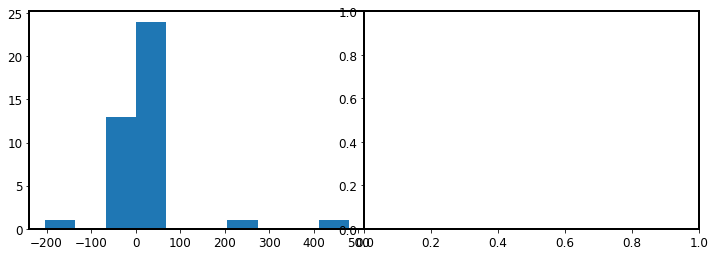

           combinatory  combinatory_not_found    std  std_not_found  \
Equation                                                              
II.11.17          -2.0                    0.0    1.0            0.0   
I.24.6           479.5                    3.0  462.5            5.0   
II.11.20           2.0                    0.0    3.0            0.0   
III.13.18          1.5                    0.0    2.0            0.0   
I.13.4            51.0                    0.0   49.5            0.0   

           complexity-std  complexity-std_not_found  loss-std  \
Equation                                                        
II.11.17              2.0                       0.0       3.0   
I.24.6              451.0                       0.0     457.0   
II.11.20              0.0                       0.0       3.0   
III.13.18             1.5                       0.0       2.0   
I.13.4               40.5                       0.0      22.5   

           loss-std_not_found  true-confusion 

In [38]:
# make one plot for each algorithm
def difference_plot_each_complexity(pdf=None, num=10, xmin=-500, xmax=500, not_found_num = 650, save_as_img=False):

    summary_df = read_data(read_from_file=True, not_found=np.nan)
    # for every algorithm, get the number of nan values
    not_found = {}
    for alg in summary_df.columns[:-1]:
        nan_count = 0
        for eq in summary_df.index:
            # get the number of nan values
            step_list = summary_df.loc[eq, alg]
            # Convert the step_list to a numeric NumPy array if applicable
            if isinstance(step_list, list):
                step_list = np.array(step_list, dtype=np.float64)
                
            # count the number of nan values in the list
            try:
                nan_count_eq = np.count_nonzero(np.isnan(step_list))
            except TypeError as e:
                raise TypeError(f"Error in {alg} with {eq} and {alg}") from e
            # add to the total nan count
            nan_count += nan_count_eq
        not_found[alg] = nan_count

    from scipy.stats import norm
    bins = linspace_with_zero(xmin, xmax, num+1, log=True)
    palette = sns.color_palette()[1:6]
    median_difference_df = median_difference(not_found_num = not_found_num)

    
    

    for i, algo in enumerate(ALGORITHMS[1:]):
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        fig.subplots_adjust(wspace=0.0, hspace=0.5)

        
        N, bins, patches = ax[0].hist(x=median_difference_df[algo])
        
        # complexity is the number of nodes that the equations expression tree consists of
        # get complexity of current equation
        plt.show()

        print(median_difference_df.head())
        print(N)
        print(bins)
        print(patches)

        return
        


        # add the percentage of median_difference_df entries that are less than 0 and greater than 0 to the plot in form of a text box
        # get the number of entries that are less than 0 and greater than 0
        less_than_zero = median_difference_df[median_difference_df[algo] <= 0][algo].count()
        greater_than_zero = median_difference_df[median_difference_df[algo] > 0][algo].count()
        # calculate the percentage
        less_than_zero_percentage = less_than_zero / median_difference_df[algo].count() * 100
        greater_than_zero_percentage = greater_than_zero / median_difference_df[algo].count() * 100
        # add the text boxes to the middle left and right of the histogram
        ax[0].text(0.25, 0.50, f"{less_than_zero_percentage:.2f}%", transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor="black"), horizontalalignment='center')
        ax[0].text(0.75, 0.50, f"{greater_than_zero_percentage:.2f}%", transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor="black"), horizontalalignment='center')
        # plot the empirical median and standard deviation
        median = np.nanmean(median_difference_df[algo])
        std = np.nanstd(median_difference_df[algo], ddof=1)
        # count the not found values for the algorithm in every equation. They have a value of not_found_num
        not_found_sum = int(not_found[algo])
        ax[0].text(0.02, 0.95, f"$\\mu = {median:.2f}, \\sigma = {std:.2f}$\nEQs not found = {not_found_sum}",
                transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="black"))
        # add a vertical line at 0
        ax[0].axvline(0, color="black", linestyle='--', linewidth=2)
        ax[1].axvline(0, color="black", linestyle='--', linewidth=2)

        
        # add a boxplot to the lower right
        #sns.violinplot(data=median_difference_df[algo], ax=ax[1], color=palette[i], inner=None, linewidth=0, orient="h", )
        sns.boxplot(data=median_difference_df[algo], ax=ax[1], color=palette[i], linewidth=3, orient="h", boxprops={'zorder': 2}, width=0.4)
        
        
        # make x axis logarithmic
        ax[1].set_xscale("symlog")
        #ax["upper right"].set_xscale("symlog")
        ax[0].set_xscale("symlog")
        # set x ticks
        ax[1].set_xticks(bins)
        ax[1].set_xticklabels(bins, minor=False)
        ax[1].set_xticks([], minor=True)
        ax[0].set_xticks(bins)
        ax[0].set_xticklabels(bins, minor=False)
        ax[0].set_xticks([], minor=True)
        # title
        fig.suptitle(f"Difference in median number of steps for {algo if algo != 'true-confusion' else 'true-mod'}", fontsize=20, weight="bold")
        ax[1].set_xlabel("$median_{random} - median_{approach}$", fontsize=16)
        ax[0].set_xlabel("$median_{random} - median_{approach}$", fontsize=16)
        ax[0].set_ylabel("Equations per bin", fontsize=16)
        # remove y label from ax[1]
        ax[1].set_ylabel("")
        ax[1].set_yticks([])

        # add grid to ax[1]
        ax[1].grid(True, axis="x", zorder=0, color="grey", linestyle="--", linewidth=1)


        # add textbox with not found value in the middle of the figure, not ax[0]
        textstr = f"not found value = {not_found_num}"
        props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor="white")
        ax[1].text(0.5, 0.88, textstr, transform=fig.transFigure, fontsize=16, bbox=props, ha="center", va="center")
        
        # make subplots closer together
        plt.tight_layout()
        if pdf:
            pdf.savefig(fig)
        if save_as_img:
            plt.savefig(f"/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots/{algo}_difference_plot.jpg", dpi=150, bbox_inches='tight', pad_inches=0.0, transparent=False)
        else:
            plt.show()
        plt.close(fig)

difference_plot_each_complexity()

In [19]:
def isnumeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_complexity(eq):
    # replace "pi" with 3.14 and "**" with "^" and "(" or ")" with ""
    eq = eq.replace("pi", "3.14").replace("**", "^").replace("(", "").replace(")", "")
    
    operators = set(["+", "-", "*", "/", "^", "sqrt", "exp", "sin", "cos", "tanh"])
    # split the equation on the operators
    for op in operators:
        eq = eq.replace(op, ",")
    print(eq)

    # when a number if followed by a number, fuse them together
    split = eq.split(",")
    print(split)
    for i in range(1,len(split)):
        if isnumeric(split[i-1]) and isnumeric(split[i]):
            split[i] = split[i-1] + split[i]
            split[i-1] = ""
    eq = ",".join(split)
    print(split)

    # count the number of commas and things between them if they are not empty
    num_commas = eq.count(",")

    num_things = len([x for x in eq.split(",") if x != ""])
    # return the sum of the two
    return num_commas + num_things
print(get_complexity("exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma)"))

,,theta,sigma,2,2,,2,3.14,sigma
['', '', 'theta', 'sigma', '2', '2', '', '2', '3.14', 'sigma']
['', '', 'theta', 'sigma', '', '22', '', '', '23.14', 'sigma']
14


In [18]:
import re

def equation_complexity(expression):
    operators = set(["+", "-", "*", "/", "^", "sqrt", "exp"])
    constants = set(["pi", "e"])
    variables = set(["x", "y", "z"])  # Add more variables if needed
    
    def simplify_expression(expr):
        # Replace any known constants or variables with a single character
        replacements = {"pi": "C", "e": "C"}
        for var in variables:
            replacements[var] = "V"
        for const in constants:
            replacements[const] = "C"
        
        for old, new in replacements.items():
            expr = expr.replace(old, new)
        return expr
    
    simplified_expression = simplify_expression(expression)
    tokens = re.findall(r'\w+|\S', simplified_expression)
    
    complexity = 0
    stack = []
    
    for token in tokens:
        if token in operators:
            if token == "^":
                complexity += 1
            else:
                complexity += 1
            if token == "sqrt":
                stack.append("expr")
            elif token == "exp":
                stack.append("expr")
        elif token == "(":
            stack.append("expr")
        elif token == ")":
            if stack and stack[-1] == "expr":
                stack.pop()
            else:
                complexity += 1
        elif token in constants or token in variables:
            complexity += 1
        else:
            stack.append(token)
    
    return complexity

equation = "exp(-theta^2/2)/sqrt(4)"
complexity = equation_complexity(equation)
print("Complexity of the equation:", complexity)


Complexity of the equation: 7


,,theta,sigma,2,2,,2,3.14,sigma
['', '', 'theta', 'sigma', '2', '2', '', '2', '3.14', 'sigma']
['', '', 'theta', 'sigma', '', '22', '', '', '23.14', 'sigma']
14


In [6]:
# import feynman.csv and print 'Filename' and 'Formula' columns
import pandas as pd
df = pd.read_csv('/beegfs/desy/user/bornemaf/data/SyReAL/syreal/jobs/jobOrchestration/feynman.csv')
print(df[['Filename', 'Formula']])

     Filename                                            Formula
0      I.6.2a                        exp(-theta**2/2)/sqrt(2*pi)
1       I.6.2        exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma)
2      I.6.2b  exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...
3      I.8.14                        sqrt((x2-x1)**2+(y2-y1)**2)
4      I.9.18         G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)
..        ...                                                ...
95  III.15.14                         (h/(2*pi))**2/(2*E_n*d**2)
96  III.15.27                                   2*pi*alpha/(n*d)
97  III.17.37                          beta*(1+alpha*cos(theta))
98  III.19.51  -m*q**4/(2*(4*pi*epsilon)**2*(h/(2*pi))**2)*(1...
99  III.21.20                                 -rho_c_0*q*A_vec/m

[100 rows x 2 columns]


In [15]:
median_difference_df = median_difference(not_found_num = 650)
print(median_difference_df)

           combinatory  combinatory_not_found    std  std_not_found  \
Equation                                                              
II.11.17          -2.0                    0.0    1.0            0.0   
I.24.6           479.5                    0.0  462.5            0.0   
II.11.20           2.0                    0.0    3.0            0.0   
III.13.18          1.5                    0.0    2.0            0.0   
I.13.4            51.0                    0.0   49.5            0.0   
I.6.2b            67.5                    0.0   66.5            0.0   
I.30.3            47.5                    0.0  -76.0            0.0   
II.11.3         -204.5                    0.0 -231.0            0.0   
I.34.14          -47.5                    0.0 -159.0            0.0   
I.11.19            1.0                    0.0    0.0            0.0   
I.38.12            2.0                    0.0    1.0            0.0   
III.7.38           0.0                    0.0    1.0            0.0   
III.10

/beegfs/desy/user/bornemaf/conda/envs/PySR/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


Hier einmal ein Update zu meinen Ergebnissen: Diese Plots sind noch nicht perfekt dokumentiert, deshalb diese zusätzliche Erklärung:
Von den 100 Equations die ich ursprünglich im Datensatz hatte, habe ich 42 nutzen können (weil entweder gefunden oder nicht allzuschnell gefunden wurden). Für all diese 42 Equations habe ich 5 active sampling algorithms, sowie das random sampling mit jeweils 100 Trials suchen lassen, bis das jeweilig Modell einen Loss-Wert unterschritten hat. In einigen Trials ist dies nicht passiert bis die maximale step size (500) erreicht wurde und dieser Trial wurde als "not found" markiert. Damit diese Trials berücksichtigt werden, habe ich ihnen einen Wert (= not found value) zugewiesen.
Nun zu den Plots:
Für jede Equation wurde der Median der steps für jeden algorithm errechnet und von dem median des random samplings abgezogen (median_{random} - median_{algorithm}). Das macht also 42 Datenpunkte für jeden active sampling algorithm. Diese Werte wurden in das Histogram und den Boxplot gezeichnet. Die x-Achse ist in symlog-scale da die meisten Punkte um die Null verteilt sind. Man erkennt, dass jeder Algorithm eine rechts "Verschiebung" hat und damit dessen Median der steps in den meisten Equations kleiner war als der Median des random samplings.

In [32]:
summary_df = read_data(read_from_file=True, not_found=np.nan)
print(sum(np.isnan(summary_df["true-confusion"]["I.34.14"])))

62


In [33]:
summary_df = read_data(read_from_file=True, not_found=np.nan)
# for every algorithm, get the number of nan values
not_found = {}
for alg in summary_df.columns[:-1]:
    print(alg)
    nan_count = 0
    for eq in summary_df.index:
        # get the number of nan values
        step_list = summary_df.loc[eq, alg]
        # Convert the step_list to a numeric NumPy array if applicable
        if isinstance(step_list, list):
            step_list = np.array(step_list, dtype=np.float64)
            
        # count the number of nan values in the list
        try:
            nan_count_eq = np.count_nonzero(np.isnan(step_list))
        except TypeError as e:
            raise TypeError(f"Error in {alg} with {eq} and {alg}") from e
        # add to the total nan count
        nan_count += nan_count_eq
    not_found[alg] = nan_count

print(not_found)


random
combinatory
std
complexity-std
loss-std
true-confusion
{'random': 109, 'combinatory': 53, 'std': 83, 'complexity-std': 8, 'loss-std': 7, 'true-confusion': 87}


In [87]:
import os

folder_path = '/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots/per_equation'  # Replace with the actual path
target_folder_path = 'figures/per_equation'  # Replace with the actual path
figure_extension = '.jpg'  # Replace with the actual extension of your figure files

latex_code = '\\begin{figure}\n'
for filename in os.listdir(folder_path):
    if filename.endswith(figure_extension):
        figure_path = os.path.join(target_folder_path, filename)
        latex_code += f'  \\includegraphics[width=0.9\\textwidth]{{{figure_path}}}\n'
latex_code += '\\caption{All per-equation results}\n'
latex_code += '\\end{figure}\n'

with open('/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots/generated_figures.tex', 'w') as f:
    f.write(latex_code)


In [91]:
import os

folder_path = '/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots/per_equation'  # Replace with the actual path
target_folder_path = 'figures/per_equation'  # Replace with the actual path
figure_extension = '.jpg'  # Replace with the actual extension of your figure files

latex_code = '\\begin{figure}\n'
latex_code += '  \\centering\n'
latex_code += '  \\begin{subfigure}{0.9\\textwidth}\n'
for filename in os.listdir(folder_path):
    if filename.endswith(figure_extension):
        figure_path = os.path.join(target_folder_path, filename)
        latex_code += f'    \\includegraphics[width=\\linewidth]{{{figure_path}}}\n'
        if (os.listdir(folder_path).index(filename) + 1) % 3 == 0:  # Adjust the number of images per row (4 in this example)
            latex_code += '  \\end{subfigure}\\hfill\n'
            latex_code += '  \\begin{subfigure}{0.75\\textwidth}\n'
latex_code += '  \\end{subfigure}\n'
latex_code += '  \\caption{All per-equation results}\n'
latex_code += '\\end{figure}\n'

with open('/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots/generated_figures.tex', 'w') as f:
    f.write(latex_code)


In [102]:
import os

folder_path = '/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots/per_equation'  # Replace with the actual path
target_folder_path = 'figures/per_equation'  # Replace with the actual path
figure_extension = '.jpg'  # Replace with the actual extension of your figure files

latex_code = '\\begin{figure}[!b]\n'
latex_code += '    \\centering\n'

subfigure_counter = 0

for filename in os.listdir(folder_path):
    if filename.endswith(figure_extension):
        figure_path = os.path.join(target_folder_path, filename)

        if subfigure_counter % 3 == 0:
            latex_code += '    \\begin{subfigure}{0.9\\textwidth}\n'
        latex_code += f'        \\includegraphics[width=\\linewidth]{{{figure_path}}}\n'
        #latex_code += f'        \\subcaption{{Results for equation {filename[:-4]}}}\n'
        latex_code += f'        \\label{{fig:per_eq_{filename[:-4]}}}\n'
        latex_code += '         \\medskip\n'

        subfigure_counter += 1

        if subfigure_counter % 3 == 0:
            latex_code += '    \\end{subfigure}\n'
            latex_code += '\\end{figure}%\n\\begin{figure}[ht]\\ContinuedFloat\n    \\centering\n'

latex_code += '    \\end{subfigure}\n\\caption[Optional caption for the entire figure]{All per-equation results}\n'
latex_code += '    \\label{fig:all_per_equation_results}\n\\end{figure}\n'

with open('/beegfs/desy/user/bornemaf/data/SyReAL/notebooks/plots/generated_figures.tex', 'w') as f:
    f.write(latex_code)


## Correlation Plots

### Correlation between the algorithms in the number of steps for each equation

/beegfs/desy/user/bornemaf/conda/envs/PySR/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


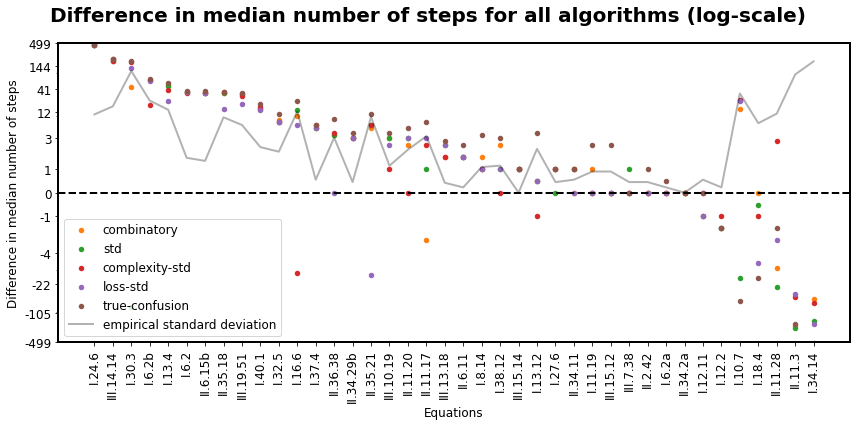

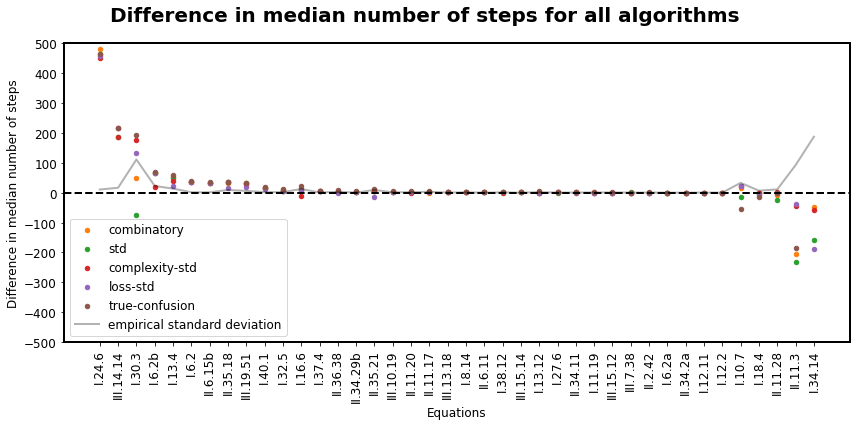

In [46]:
median_difference_df = median_difference(not_found_num = 650)
median_difference_df = median_difference_df[ALGORITHMS[1:]]

for log in [True, False]:
    # sort the equations by their mean of all algorithms
    median_difference_df = median_difference_df.reindex(median_difference_df.mean(axis=1).sort_values(ascending=False).index)
    # plot the equations on the x axis
    x = np.arange(len(median_difference_df))
    # plot the median difference on the y axis
    y = median_difference_df.values
    # y is of shape (40, 5), x is of shape (40,). In order to 

    # plot the scatter plot
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = sns.color_palette()[1:6]
    for i in range(len(ALGORITHMS[1:])):
        ax.scatter(x, y[:,i], color=colors[i], label=ALGORITHMS[i+1], s=20)
    # add a horizontal line at 0
    ax.axhline(0, color="black", linestyle='--', linewidth=2)

    # plot the empirical median and varince for each row
    median = np.nanmean(median_difference_df, axis=1)
    std = np.nanstd(median_difference_df, axis=1, ddof=1)
    # norm the std to 500
    #std = std / np.nanmax(std) * 500
    #ax.plot(x, median, color="black", linestyle='-', linewidth=2, label="empirical median")
    ax.plot(x, std, color="black", linestyle='-', linewidth=2, label="empirical standard deviation", alpha=0.3)

    # set x ticks
    ax.set_xticks(x)
    ax.set_xticklabels(median_difference_df.index, rotation=90, minor=False)
    ax.set_xticks([], minor=True)

    # set y as linspace_with_zero and log scale
    ymin = -500
    ymax = 500
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(linspace_with_zero(ymin, ymax, 11, log=False))

    if log:
        ax.set_yscale("symlog")
        # set y ticks
        ax.set_yticks(linspace_with_zero(ymin, ymax, 11, log=True))
        ax.set_yticklabels(linspace_with_zero(ymin, ymax, 11, log=True), minor=False)
    # title
    fig.suptitle(f"Difference in median number of steps for all algorithms"+f" {'(log-scale)' if log else ''}", fontsize=20, weight="bold")
    ax.set_xlabel("Equations")
    ax.set_ylabel("Difference in median number of steps")
    ax.legend()
    # make subplots closer together
    plt.tight_layout()
    plt.show()
